In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pickle 

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import layers


import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('keras').setLevel(logging.ERROR)


In [2]:
df = pd.read_csv('historic_readings_no_missing_data.csv'
        ).drop(columns=['Unnamed: 0']
        ).sort_values(by='timestamp')

Selecting only temperature data 

In [3]:
df.sort_values(by='timestamp', inplace=True)

In [5]:
df_temp =  df[ df['timestamp'] > str(pd.Timestamp('2023-04-28')) ].drop(columns=['humidity'])

df_temp.set_index('timestamp',inplace=True)
df_temp.dropna(inplace=True)

In [6]:
# Split the data, 60% in training and 20% in validation, 20% in test, and not randomly selected since this is a time series

last_train_index = int(np.round(df_temp['temperature'].shape[0]*0.6))
last_val_index = int(np.round(df_temp['temperature'].shape[0]*0.8))

train_data = df_temp.iloc[:last_train_index,]
validation_data = df_temp.iloc[last_train_index:last_val_index]
test_data = df_temp.iloc[last_val_index:]

# Fit to the train set, then transform the train set and the test set
# TODO: Check, should not fit on test set?

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
scaled_train = train_data / std

scaled_validation = (validation_data - mean)/std
scaled_test = (test_data - mean)/std


print(f'Mean of training data: {mean},'
      f'\nStandard deviation of training data: {std}')



Mean of training data: temperature    22.981637
dtype: float64,
Standard deviation of training data: temperature    2.30707
dtype: float64


Creating the generators. The task will be to take in one hour of readings, spaced 10 minutes apart, and predict the temperature in two hours. 

For example, there will be readings at 3:00pm, 3:10pm, ..., 4:00pm, and the task will be to predict the temperature at 6pm. 

In [7]:
delay = 24
sequence_length = 12

In [8]:
example_generator = keras.preprocessing.timeseries_dataset_from_array(np.arange(50)[:-delay], np.arange(50)[sequence_length+delay:],
    sequence_length=sequence_length, batch_size=1, shuffle=False)
    
for inputs, targets in example_generator:
    print(f'Input: {inputs}, targets: {targets}')

Input: [[ 0  1  2  3  4  5  6  7  8  9 10 11]], targets: [36]
Input: [[ 1  2  3  4  5  6  7  8  9 10 11 12]], targets: [37]
Input: [[ 2  3  4  5  6  7  8  9 10 11 12 13]], targets: [38]
Input: [[ 3  4  5  6  7  8  9 10 11 12 13 14]], targets: [39]
Input: [[ 4  5  6  7  8  9 10 11 12 13 14 15]], targets: [40]
Input: [[ 5  6  7  8  9 10 11 12 13 14 15 16]], targets: [41]
Input: [[ 6  7  8  9 10 11 12 13 14 15 16 17]], targets: [42]
Input: [[ 7  8  9 10 11 12 13 14 15 16 17 18]], targets: [43]
Input: [[ 8  9 10 11 12 13 14 15 16 17 18 19]], targets: [44]
Input: [[ 9 10 11 12 13 14 15 16 17 18 19 20]], targets: [45]
Input: [[10 11 12 13 14 15 16 17 18 19 20 21]], targets: [46]
Input: [[11 12 13 14 15 16 17 18 19 20 21 22]], targets: [47]
Input: [[12 13 14 15 16 17 18 19 20 21 22 23]], targets: [48]
Input: [[13 14 15 16 17 18 19 20 21 22 23 24]], targets: [49]


2023-08-31 13:56:56.588526: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [14]
	 [[{{node Placeholder/_8}}]]
2023-08-31 13:56:56.588789: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


In [9]:
train = keras.preprocessing.timeseries_dataset_from_array(scaled_train[:-delay], scaled_train[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

validation = keras.preprocessing.timeseries_dataset_from_array(scaled_validation[:-delay], scaled_validation[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

test = keras.preprocessing.timeseries_dataset_from_array(scaled_test[:-delay], scaled_test[sequence_length+delay:], 
                            sequence_length=sequence_length, batch_size=1, shuffle=True)

### Baseline persistence forecast

We define a baseline persistence forecast. This simply the average MAE. 

In [10]:
def evalute_naive_method(dataset):

    total_abs_err = 0
    predictions = 0

    for inputs, targets in dataset:
        
        # We take the last value from the input tensor
        preds = inputs[:, -1]
        total_abs_err += np.sum(np.abs(preds-targets))
        predictions += 1

    return total_abs_err / predictions

persistence_mae = evalute_naive_method(test) 

print(f'Baseline: persistence forecast for 2 hours - MAE: {persistence_mae*100:.2f}%')

2023-08-31 13:57:10.061776: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [3298]
	 [[{{node Placeholder/_28}}]]
2023-08-31 13:57:10.062309: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [3298]
	 [[{{node Placeholder/_28}}]]


Baseline: persistence forecast for 2 hours - MAE: 19.66%


### First LSTM model

In [79]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(12)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=5,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)



Epoch 1/5


2023-08-31 12:10:12.671246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [9978,1]
	 [[{{node Placeholder/_0}}]]
2023-08-31 12:10:12.671556: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [9978,1]
	 [[{{node Placeholder/_0}}]]


9940/9966 [============================>.] - ETA: 0s - loss: 0.0963 - mae: 0.2401

2023-08-31 12:10:30.559827: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-08-31 12:10:30.560142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [3298]
	 [[{{node Placeholder/_28}}]]


9966/9966 [==============================] - 20s 2ms/step - loss: 0.0963 - mae: 0.2401 - val_loss: 0.0495 - val_mae: 0.1757
Epoch 2/5
9966/9966 [==============================] - 19s 2ms/step - loss: 0.0730 - mae: 0.2077 - val_loss: 0.0465 - val_mae: 0.1646
Epoch 3/5
9966/9966 [==============================] - 22s 2ms/step - loss: 0.0687 - mae: 0.2005 - val_loss: 0.0455 - val_mae: 0.1614
Epoch 4/5
9966/9966 [==============================] - 20s 2ms/step - loss: 0.0664 - mae: 0.1950 - val_loss: 0.0441 - val_mae: 0.1587
Epoch 5/5
9966/9966 [==============================] - 19s 2ms/step - loss: 0.0646 - mae: 0.1904 - val_loss: 0.0434 - val_mae: 0.1573


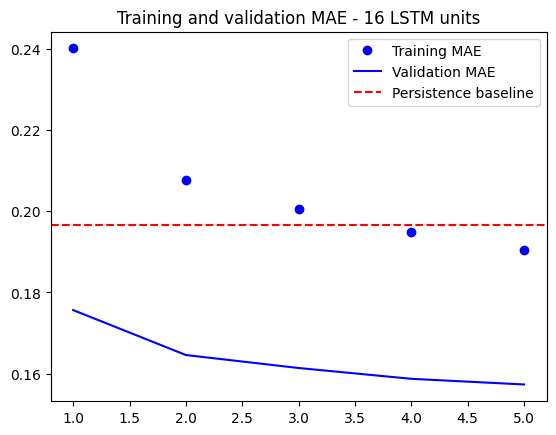

In [80]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [86]:
model.evaluate(test)

3298/3298 [==============================] - 2s 595us/step - loss: 0.0457 - mae: 0.1788


[0.04567280411720276, 0.17875972390174866]

### Using dropout to fight overfitting

In [15]:
inputs = keras.Input(shape=(12, 1))

x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train,
                    epochs=30,
                    validation_data=validation)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

Epoch 1/30
9966/9966 [==============================] - 31s 3ms/step - loss: 0.0995 - mae: 0.2415 - val_loss: 0.0490 - val_mae: 0.1720
Epoch 2/30
9966/9966 [==============================] - 30s 3ms/step - loss: 0.0894 - mae: 0.2306 - val_loss: 0.0503 - val_mae: 0.1744
Epoch 3/30
9966/9966 [==============================] - 30s 3ms/step - loss: 0.0858 - mae: 0.2265 - val_loss: 0.0534 - val_mae: 0.1805
Epoch 4/30
9966/9966 [==============================] - 31s 3ms/step - loss: 0.0846 - mae: 0.2245 - val_loss: 0.0526 - val_mae: 0.1787
Epoch 5/30
9966/9966 [==============================] - 30s 3ms/step - loss: 0.0825 - mae: 0.2218 - val_loss: 0.0518 - val_mae: 0.1790
Epoch 6/30
9966/9966 [==============================] - 30s 3ms/step - loss: 0.0813 - mae: 0.2196 - val_loss: 0.0542 - val_mae: 0.1820
Epoch 7/30
9966/9966 [==============================] - 30s 3ms/step - loss: 0.0795 - mae: 0.2170 - val_loss: 0.0546 - val_mae: 0.1841
Epoch 8/30
9966/9966 [==============================] -

In [12]:
persistence_mae

0.19658639424505764

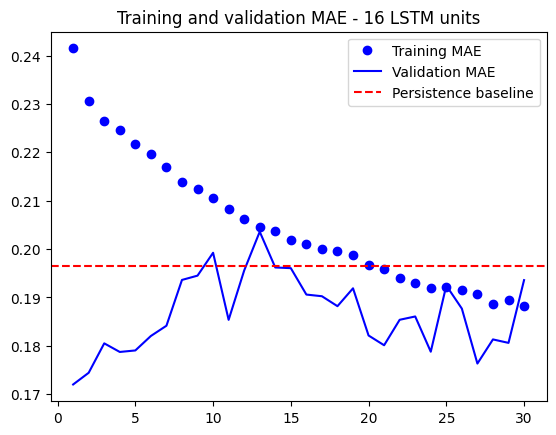

In [16]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.axhline(y=persistence_mae, color='r', linestyle='--', label='Persistence baseline')
plt.title(f'Training and validation MAE - 16 LSTM units')
plt.legend()
plt.show()

In [17]:
model.evaluate(test)

   1/3298 [..............................] - ETA: 1:14 - loss: 0.0240 - mae: 0.1550

3298/3298 [==============================] - 2s 694us/step - loss: 0.0459 - mae: 0.1677


[0.04586951434612274, 0.16767916083335876]

We have a model which outperforms the baseline and the non-dropout LSTM. 

In [20]:
# Ok let's just deploy 

model.save('regularised_lstm.keras')

print(std)
print(mean)

temperature    2.30707
dtype: float64
temperature    22.981637
dtype: float64
